# Supplementary code for the paper "Sodium–Calcium Exchanger Can Account for Regenerative Ca$^{2+}$ Entry in Thin Astrocyte Processes"


*A. R. Brazhe (https://orcid.org/0000-0002-1495-4652), A. Yu. Verisokin (http://orcid.org/0000-0002-3655-7682), D. V. Verveyko (https://orcid.org/0000-0003-3661-3928), D. E. Postnov (https://orcid.org/0000-0002-6575-0975)*

published in *Frontiers in Cellular Neuroscience*; **DOI:** 10.3389/fncel.2018.00250



A model of the Na/Ca exchanger, its modulation by cytosolic sodium and calcium, and implications for astrocytic calcium dynamics. The model is based on the Weber et al 2001 model, with added Na-dependent inactivation as a Hodgkin–Huxley-type gating variable.

Reference implementation, simulation and parameter values. Figures from the paper are reproduced. 

## Initialize and define some constants and helper functions

In [15]:
rc('axes',grid=True)
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
#mpl.rc('xlabel',size=18)
#mpl.rc('ylabel',size=18)
mpl.rc('font',size=16)

In [9]:
def hill(x, Kh,n):
    xn = x**n
    return xn/(xn + Kh**n)

def rescale(v):
    return (v-v.min())/(v.max()-v.min())


def simpleaxis(ax,level=1):
    """plot only x and y axis, not a frame for subplot ax"""
    hide = ['top', 'right','bottom', 'left']
    for key in hide:
        ax.spines[key].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    sides = [ax.get_xaxis(),]#ax.get_yaxis()
    if level > 1:
        for t in ax.get_xaxis().get_ticklabels():
            t.set_visible(False)
    if level > 2:
        for t in ax.get_yaxis().get_ticklabels():
            t.set_visible(False)
    if  level > 3:
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

def softmax(x):
    "a simple workaround to avoid dividing by zero"
    return clip(x, 1e-12,x)


In [10]:
F = 96500 # [Coulomb/mole]
R = 8.314 # [J/mole/K]
lab_temperature = 37.0 # Celsius

T = 273.15 + lab_temperature # K
Vastro = -80. # mV

def Encx(ccai,cnai):
    "Reversal potential of NCX, Cna [mM], Cca [uM]"
    ena = Nernst(csf['Na'],cnai)
    eca = Nernst(csf['Ca'],ccai*1e-3,2)
    return 3*ena-2*eca

def Nernst(Cout,Cin,z=1):
    "Nernst potential in mV"
    return 1000.*(R*T/(z*F))*log(Cout/softmax(Cin))  # never divides by zero


# Remember we use [Ca]o in mM and [Ca]i in uM

# Ion concentrations in aCSF and astrocyte cytoplasm [mM]
csf = dict(K=3,Na=145,Ca=1.2,Cl=130)              # Verkhratsky,Nedergaard (2018)
cyt = dict(K=130,Na=16,Ca=75*1e-3,Cl=50)          # Verkhratsky,Nedergaard (2018)

pv3 = 0.0   # uM/s, Max Ca2+ uptake by SERCA? pump
pk3 = 0.1   # uM, Activation constant for Ca2+-pump

ncx_pars = dict(
        eta = 0.35,
        KmCao = 1.3, # mM
        KmNai = 12.3, #mM
        KmCai = 0.0026, #mM
        ksat = 0.25,
        nHill = 2.0,
        KmCaAct=130e-3, # uM
)

ncx_pars['KmNao'] = ncx_pars['KmNai']*(ncx_pars['KmCao']/ncx_pars['KmCai'])**(1/3)

In [11]:
ncx_pars

{'KmCaAct': 0.13,
 'KmCai': 0.0026,
 'KmCao': 1.3,
 'KmNai': 12.3,
 'KmNao': 97.62516469604427,
 'eta': 0.35,
 'ksat': 0.25,
 'nHill': 2.0}

In [12]:
# ---- Na dependence ----
# inactivation by Na+ (Inactivation state I1)
def hinf(Cna,Cca,Kna=5, Kca=0.8,hill_na=2,hill_ca=2):
    u = 1./(1 + (Cca/Kca)**hill_ca)
    return 1 - u*hill(Cna,Kna,hill_na)

def htau(Cca,Kca=1.0,tau0=10,hill=1.0):
    return 0.25+tau0/(1 + (Cca/Kca)**hill)


# ---- Ca dependence (high-affinity)/ release from inactivated state I2 ----
def ninf(Cca, Kca=0.1, H=2):
    return hill(Cca, Kca, H)

In [13]:
def JncxΔE(ccai, cnai, V=Vastro, p=ncx_pars):
    """'Electrochemical' component of the NCX-mediated Ca flux, no allosteric modulation"""
    FoRT = F*1e-3/R/T
    η = p['eta']
    ccai_mM = ccai*1e-3
    cnai3 = cnai**3
    ΔE  = (cnai3*csf['Ca']*exp(η*V*FoRT) - csf['Na']**3*ccai_mM*exp((η-1)*V*FoRT))
    denom = (p['KmCao']*cnai3 + 
             p['KmNao']**3*ccai_mM + 
             p['KmNai']**3*csf['Ca']*(1 + ccai_mM/p['KmCai']) + 
             p['KmCai']*csf['Na']**3*(1+(cnai/p['KmNai'])**3) + 
             cnai3*csf['Ca'] + 
             csf['Na']**3*ccai_mM)*(1 + p['ksat']*exp((η-1)*V*FoRT))
    ΔE = ΔE/denom
    return ΔE

def Jncx(ccai, cnai, h, Jmax=1., V=Vastro, p=ncx_pars):
    "NCX-mediated Ca flux with allosteric modulation"
    ΔE = JncxΔE(ccai,cnai,V,p)
    return Jmax*h*ninf(ccai)*ΔE
   

In [14]:
nav = linspace(0.01,100,250)
cav2 = array([0.01, 0.1, 0.3, 0.5,1.0])

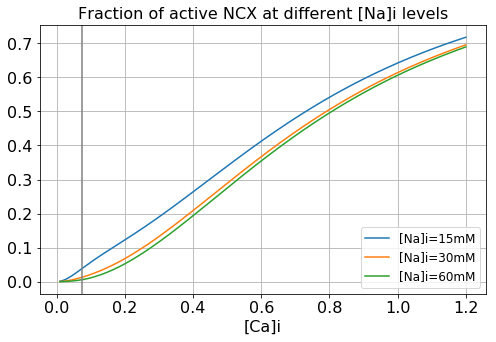

In [18]:
figure(figsize=(8,8*0.618))
cav=linspace(0.01, 1.2, 200)
navx = [15,30,60]
for nav in navx:
    plot(cav, ninf(cav,0.1,H=2)*hinf(nav,cav),label='[Na]i=%dmM'%nav)
axvline(cyt['Ca'], color='gray')
xlabel('[Ca]i'); 

title('Fraction of active NCX at different [Na]i levels',fontsize=16)
legend(fontsize=12)

## ODE

In this section we integrate point models of the NCX. First, a model where [Na]i is a parameter is used for phaseplane analysis. Next, a model with both Ca and Na as dynamic variables is simulated.

In [74]:
from scipy.interpolate import UnivariateSpline as usp

def adams_bashforth(rhs, init_state, dt=0.25, tstart=0, tstop=500,  fnkwargs=None):
    """Simple function to integrate a set of ODEs
    Inputs:
       rhs : callable, calculates right-hand sides of ODEs
       init_state: initial state as a 1D vector
       dt : fixed time step
       tstart: time at start of integration
       tsopt: integrate until this time
       fnkwargs: dictionary with optional parameters for the rhs function
    """
    if fnkwargs is None:
        fnkwargs = {}
        
    #ndim = len(init_state)
    sh = asarray(init_state).shape
    tv = arange(tstart,tstop,dt)
    xout = zeros((len(tv),)+ sh)
    xout[0] = init_state
    fprev = array(rhs(xout[0], tv[0], **fnkwargs))
    xnew = xout[0] + dt*fprev
    xout[1] = xnew
    for k,t in enumerate(tv[1:-1]):
        xprev,xcurr = xout[k:k+2]
        fnew = array(rhs(xcurr, t,**fnkwargs))
        xnew = xcurr + dt*(3*fnew/2.0 - fprev/2.0)
        fprev = fnew
        xout[k+2] = xnew
    return tv, xout

## Smooth interpolated pulses

def I_pulse(tx, amp, start, stop,k=10):
    "Creates single pulse with given amplitude, start and stop times"
    return amp*0.5*(1 + tanh(k*(tx-start)) * tanh(k*(-tx+stop)))

def make_pulses(tv, npulses=5, period=5, start=100, amp=5, width=1,steep=1.,base=0):
    "Creates a set of pulses for stimulation currents"
    onsets = arange(start, start+npulses*period,period)
    y = base+np.sum(I_pulse(tv, amp-base, on, on+width,k=steep) for on in onsets)
    return usp(tv, y, s=0)

def combine_interpolations(tv, signals):
    "Merges several interpolated signals into one interpolation"
    y = np.sum(s(tv) for s in signals)
    return usp(tv, y, s=0)

### Both [Na]i and [Ca]i are parameters

In [24]:
def clamped_ncx(state,t,jna=lambda t:0, jca=lambda t:0):
    "Weber-type NCX model with both [Ca]i and [Na]i as parameters"
    h, = state
    ccai = cyt['Ca'] + jca(t) 
    cnai = cyt['Na'] + jna(t)
    dh = (hinf(cnai,ccai)-h)/htau(ccai)
    return array([dh])

In [22]:
Na_pulse = make_pulses(arange(0,10000,0.2), 1, period=1200, start=100,amp=85.0,width=50,steep=2.,base=0.)
Ca_pulse = make_pulses(arange(0,10000,0.2), 1, period=1200, start=1,amp=1.0,width=300,steep=2.,base=0.)

ca_amps = [0.01, 0.1, 0.3, 0.5,1.0]


Ca_pulses = [make_pulses(arange(0,10000,0.2), 1, period=1200, start=1,amp=amp,width=300,steep=2.,base=0.)
             for amp in ca_amps]

na_amps = (6,12,25,50)
Na_pulses = [make_pulses(arange(0,10000,0.2), 1, period=1200, start=100,amp=amp,width=50,steep=2.,base=0.)
             for amp in na_amps]

In [25]:
csf['Na'] = 0.001
csf['Ca'] = 8
cyt['Na'] = 0.001


trajs = []
for napulse in Na_pulses:
    tv0, traj0 = adams_bashforth(clamped_ncx, [0.1], dt=0.01,tstop=310, fnkwargs=dict(jna=napulse,jca=Ca_pulse))
    trajs.append(traj0)

Text(0,0.5,'Jncx')

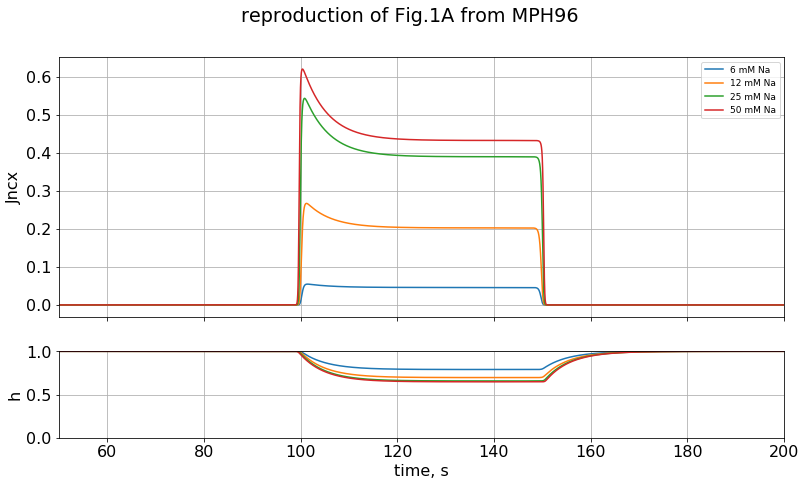

In [28]:
f,(ax1,ax2) = subplots(2,1,sharex=True,figsize=(13,7), gridspec_kw=dict(height_ratios=(3,1)))

#ax2.plot(tv0, cyt["Ca"] + Ca_pulse(tv0),label='[Ca]i,mM')
    
max_jx = []
ss_jx = []
for amp, traj,pulse in zip(na_amps, trajs,Na_pulses):
    jx = Jncx(Ca_pulse(tv0),cyt['Na'] + pulse(tv0),traj[:,0],V=0) # V=0 in Matsuoka
    max_jx.append(jx[tv0>40].max())
    ss_jx.append(jx[tv0>190][0])
    ax1.plot(tv0, jx,label='%0.0f mM Na'%amp)
    ax2.plot(tv0,traj)
    #ax1.plot(tv0,traj0[:,0])
    #ax2.plot(tv0,( pulse(tv0)),label='[Na]i, mM')
#ax1.set_ylim(-5, 80)
ax1.legend(fontsize=9)
xlim(50,200)
ax2.legend(fontsize=9)
ax2.set_ylim(0,1)
ax2.set_ylabel('h')
suptitle("reproduction of Fig.1A from MPH96")
xlabel('time, s')
ax1.set_ylabel('Jncx')

In [29]:
trajs = []
for pulse in Ca_pulses:
    tv0, traj0 = adams_bashforth(clamped_ncx, [0.57], dt=0.01,tstop=310, fnkwargs=dict(jna=Na_pulse,jca=pulse))
    trajs.append(traj0)

Text(0,0.5,'Jncx')

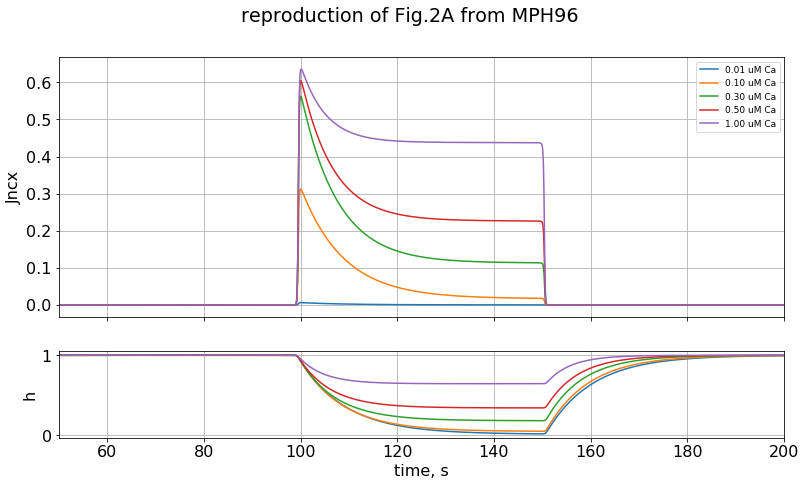

In [30]:
f,(ax1,ax2) = subplots(2,1,sharex=True,figsize=(13,7),gridspec_kw=dict(height_ratios=(3,1)))

#ax2.plot(tv0, cyt["Na"] + Na_pulse(tv0),label='[Na]i,mM')
    
for amp, traj,pulse in zip(ca_amps, trajs,Ca_pulses):
    jx = Jncx(pulse(tv0),cyt['Na'] + Na_pulse(tv0),traj[:,0],V=0)
    ax1.plot(tv0, jx,label='%0.2f uM Ca'%amp)
    #ax1.plot(tv0,traj0[:,0])
    ax2.plot(tv0,traj,label='_[Ca]i, uM, x100')
#ax1.set_ylim(-5, 80)
ax1.legend(fontsize=9)
ax2.set_ylabel('h')
xlim(50,200)
#ax2.legend(fontsize=9)
suptitle('reproduction of Fig.2A from MPH96')
xlabel('time, s')
ax1.set_ylabel('Jncx')

In [31]:
# Ion concentrations in aCSF and astrocyte cytoplasm [mM]
csf = dict(K=3,Na=145,Ca=1.2,Cl=130)              # Verkhratsky,Nedergaard (2018)
cyt = dict(K=130,Na=16,Ca=75*1e-3,Cl=50)          # Verkhratsky,Nedergaard (2018)

### Model where [Na]i is a parameter: phaseplane

In [36]:
def clamped_na_ncx_w(state,t,jna=lambda t:0, jca=lambda t:0,tau_ex=10.,Jmax=10.,V=Vastro):
    "NCX model with [Ca]i and h (inactivation) as variables"
    ccai,h = state 
    cnai = cyt['Na'] + jna(t)
    jx = Jncx(ccai,cnai,h,Jmax=Jmax,V=V) # electric current, mediated by NCX
    dca = jca(t) + jx + (cyt['Ca']-ccai)/(tau_ex) #-jpump 
    
    dh = (hinf(cnai,ccai)-h)/(htau(ccai)/1.0)
    
    return array([dca,dh])

In [37]:
def ca_nullcline(cca,cna,jbias,tau_ex=10.,Jmax=1,V=Vastro):
    return (-jbias - (cyt['Ca']-cca)/tau_ex)/Jncx(cca,cna,1,Jmax,V)

In [38]:
cav = linspace(0.001,15,1000)
cnav = linspace(5, 150, 10)

cna = 20
cna2 = 50


cyt['Ca'] = 0.075


jca_app = 0.0
pars = dict(Jmax=40, V =-75, tau_ex = 2.)

cav = ma.masked_where(abs(pars['V']-Encx(cav,cna))<0.1,cav)
cav = ma.masked_where(abs(pars['V']-Encx(cav,cna2))<0.1,cav)


init_state = [0.075, 0.4]

tv0, traj0 = adams_bashforth(clamped_na_ncx_w, init_state, dt=0.05,tstop=310, 
                             fnkwargs=dict(jna=lambda t:cna-cyt['Na'],jca=lambda t:0,**pars))

tv1, traj1 = adams_bashforth(clamped_na_ncx_w, [0.6,0.05], dt=0.05,tstop=310, 
                             fnkwargs=dict(jna=lambda t:cna2-cyt['Na'],jca=lambda t:jca_app,**pars))

tv2, traj2 = adams_bashforth(clamped_na_ncx_w, [0.8,0.05], dt=0.05,tstop=310, 
                             fnkwargs=dict(jna=lambda t:cna2-cyt['Na'],jca=lambda t:jca_app,**pars))

In [54]:
from scipy import ndimage
from functools import partial, reduce
import operator as op

def valid_loc(loc,shape):
    "Test if location not outside bounds"
    return reduce(op.__and__, [(0 <= x < s) for x,s in zip(loc,shape)])

def neighbours_x(loc,shape):
    """Return list of ajacent locations for a n-dimensional location
    """
    n = len(loc)
    d = np.diag(np.ones(n))
    x = np.concatenate((d,-d)) + loc
    return list(filter(partial(valid_loc, shape=shape), list(map(tuple, x))))


def map_attractors(ca_range=(0,1), h_range=(0,0.6),start_step=5,niters=5,dt=0.05,tstop=310):
    out = zeros((start_step, start_step))
    step = start_step
    def _map_borders(m,tol=0.05):
        nr,nc = m.shape
        bmap = zeros(m.shape,dtype=bool)
        for r in range(nr):
            for c in range(nc):
                neighs = neighbours_x((r,c), (nr,nc))
                neighs = asarray(neighs,dtype=int)
                #print (neighs)
                #print(out[neighs[0]])
                bmap[r,c] = ~np.all([abs(out[r,c]-out[tuple(n)])<tol for n in neighs])
        return bmap
                
    for i in range(niters):
        if i==0:
            borderline_mask = ones(out.shape, dtype=bool)
        else:
            borderline_mask = _map_borders(out)
        print(i,step, out.shape,sum(borderline_mask))

        for c,sca in enumerate(linspace(*ca_range,num=step)):
            for r, sh in enumerate(linspace(*h_range,num=step)):
                if borderline_mask[r,c]:
                    tvx, trajx = adams_bashforth(clamped_na_ncx_w, [sca,sh],  dt=dt,tstop=tstop, 
                             fnkwargs=dict(jna=lambda t:cna2-cyt['Na'],jca=lambda t:jca_app,**pars))
                    out[r,c]=trajx[-1,0]
        if i == niters-1:
            break
        step = step*2
        out = ndimage.zoom(out,2,mode='constant',order=0)
    return out

In [64]:
start_ca = linspace(0.0,1,5)
start_h = linspace(0.0,0.6,5)

In [55]:
%time domains = map_attractors(niters=8,start_step=4)

0 4 (4, 4) 16
1 8 (8, 8) 17
2 16 (16, 16) 35
3 32 (32, 32) 73
4 64 (64, 64) 149
5 128 (128, 128) 297
6 256 (256, 256) 601
7 512 (512, 512) 1269
CPU times: user 5min 10s, sys: 1.25 s, total: 5min 11s
Wall time: 5min 9s


In [60]:
from scipy.interpolate import UnivariateSpline as usp
def fixed_points(cna,V,Jmax=45):
    cav = linspace(0.05,5,500)
    #ma.masked_where(abs(V-ncx.Encx(cav,cna))<0.1,cav)
    cav = cav[abs(V-Encx(cav,cna))>1]
    y = ca_nullcline(cav, cna,0, Jmax=Jmax, V=V, tau_ex=2.) - hinf(cna,cav)
    yf = usp(cav, clip(y,-100,100),s=0)
    return yf.roots()

In [61]:
fps = fixed_points(cna2,pars['V'],pars['Jmax'])
fps_0 = fixed_points(cna,pars['V'],pars['Jmax'])

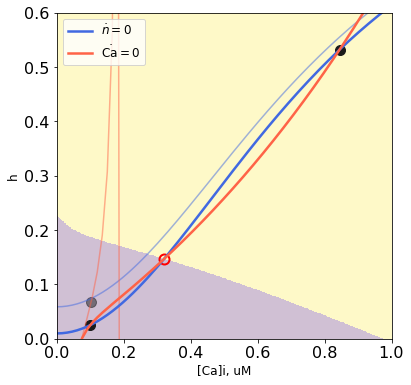

In [69]:
figure(figsize=(6,6))

imshow(domains>0.5, extent=(start_ca[0],start_ca[-1],start_h[0],start_h[-1]),
       origin='lower',zorder=-2,#cmap=cm.PiYG_r, 
       aspect='auto', interpolation='nearest',alpha=0.25)

plot(cav, hinf(cna,cav),color='royalblue', ls='-', label='_$\dot n=0$',alpha=0.5)
plot(cav, ca_nullcline(cav, cna, jca_app,**pars), color='tomato', ls='-',
     alpha=0.5,label='_$\dot \mathrm{Ca}=0$')



plot(cav, hinf(cna2,cav),color='royalblue', label='$\dot n=0$',lw=2.5)
plot(cav, ca_nullcline(cav, cna2, jca_app,**pars),lw=2.5, color='tomato',label='$\dot \mathrm{Ca}=0$')

plot(fps_0[0]-0.003,ca_nullcline(fps_0[0]-0.003,cna,jca_app,**pars),'o',color=(0.1,)*3,ms=10,zorder=-1,alpha=0.5)

plot(fps[0],ca_nullcline(fps[0],cna2,jca_app,**pars),'o',color=(0.1,)*3,ms=10,zorder=-1)
plot(fps[1],ca_nullcline(fps[1],cna2,jca_app,**pars),'ro',mfc='none',ms=10,zorder=-1,markeredgewidth=2)
plot(fps[2],ca_nullcline(fps[2],cna2,jca_app,**pars),'o',color=(0.1,)*3,ms=10,zorder=-1)


legend(loc=2,fontsize=12)

xlabel('[Ca]i, uM',fontsize=12); ylabel('h',fontsize=12)

ylim(0, 0.6)
xlim(0,1.0)
grid(False)

## Model with [Na]i and [Ca]i as dynamic variables

In [103]:
def ncx_model(state,t,jna=lambda t:0, jca=lambda t:0, tau_ex=2.,tau_na=6.,r=1.,Jmax=0.5,V=Vastro,p=ncx_pars):
    "Weber-Ginsburg type NCX model with [Ca]i,[Na]i and h (inactivation) as variables"
    ccai,cnai, h = state
    j = Jncx(ccai,cnai,h,Jmax=Jmax,V=V,p=p) # electric current, mediated by NCX
    jnoreg = Jmax*JncxΔE(ccai,cnai,V,p)
    
    jx = (r*j + (1-r)*jnoreg)
    dna = jna(t) + (cyt['Na']-cnai)/tau_na - 3*jx
    dca = jca(t) + jx + (cyt['Ca']-ccai)/(tau_ex)
    dh = (hinf(cnai,ccai)-h)/(htau(ccai)/1.0)
    
    return array([dca,dna,dh])


In [104]:
Na_pulse = make_pulses(arange(0,10000,0.2), 1, period=1200, start=100,amp=3.5,width=700,steep=5.,base=0.)
Ca_pulse = make_pulses(arange(0,10000,0.2), 2, period=800, start=350,amp=1.0,width=1.0,steep=5.,base=0.)

### Short-pulse protocols

In [105]:
Na_pulse_params_ = dict(npulses=4, start=0, period=40, amp=20.,width=0.5,steep=5.,base=0)
Na_pulse_params2_ = dict(npulses=4, start=60, period=40, amp=40.,width=0.5,steep=5.,base=0)

Ca_pulse_params_ = dict(npulses=5, start=20+0.3, period=20, amp=1., width=0.5, steep=5., base=0)

tstim = arange(-200,1e4, 0.2)
Na_pulse_1= make_pulses(tstim, **Na_pulse_params_)
Na_pulse_2= make_pulses(tstim, **Na_pulse_params2_)

Na_pulse = combine_interpolations(tstim,[Na_pulse_1,Na_pulse_2])
Ca_pulse = make_pulses(tstim, **Ca_pulse_params_)

In [106]:
shared_params = dict(Jmax=45, jna=Na_pulse,jca=Ca_pulse,tau_ex=2.0,V=-75)

shared_params['p'] = ncx_pars

ncx_block_p = shared_params.copy()
ncx_noreg_p = shared_params.copy()

ncx_p = shared_params.copy()
ncx_jna_only = shared_params.copy()
ncx_jca_only = shared_params.copy()

ncx_jna_only['jca'] = lambda t:0
ncx_jca_only['jna'] = lambda t:0

ncx_block_p['Jmax'] = 0
ncx_noreg_p['r'] = 0

In [107]:
%%time 
init_st = array([cyt['Ca'], cyt['Na'], 0.1])
numeric = dict(dt=0.025,tstart=-50, tstop=150)
tv0, traj0a = adams_bashforth(ncx_model, init_st, fnkwargs=ncx_jna_only, **numeric)
tv0, traj0b = adams_bashforth(ncx_model, init_st, fnkwargs=ncx_jca_only, **numeric)
tv1, traj1 = adams_bashforth(ncx_model, init_st, fnkwargs=ncx_p, **numeric)

CPU times: user 1.34 s, sys: 52.7 ms, total: 1.39 s
Wall time: 1.26 s


In [108]:
baseline = traj1[1000:2000,0].mean()

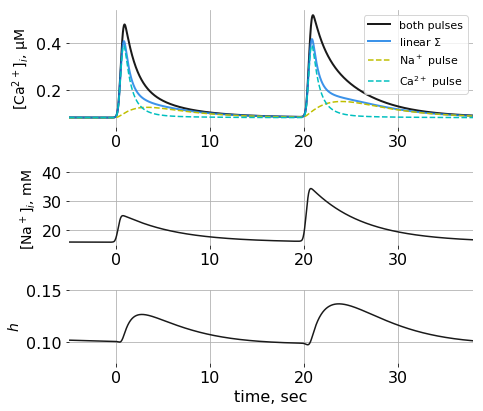

In [109]:
# plot(tv,traj0[:,0])
#ylim(0.25,0.3)

timeshift=40

color0=(0.1, 0.5, 0.9, 0.85)
color1=(0.1, 0.9, 0.5, 0.5)
color=(0.1,)*3

ylinear = -baseline+(traj0b[:,0]+traj0a[:,0])

f,axs = subplots(3,1,sharex=True,figsize=(7,6),gridspec_kw=dict(height_ratios=(1.618,1,1)))

axs[0].plot(tv1-timeshift, traj1[:,0],color=color, label='both pulses',lw=2)
axs[0].plot(tv0-timeshift, ylinear,color=color0,label='linear $\Sigma$',lw=2)
axs[0].plot(tv0-timeshift, traj0a[:,0],'--',color='y',label='Na$^+$ pulse')
axs[0].plot(tv0-timeshift, traj0b[:,0],'--',color='c',label='Ca$^{2+}$ pulse')
#setp(axs[0],ylim=(0.07,0.5),yscale='log')

ydiff = traj1[:,0]-ylinear

axs[1].plot(tv1-timeshift, traj1[:,1],color=color,label='_[Na]$_i$ [mM]')
setp(axs[1],ylim=(15,40),yticks=[20,30,40])

axs[2].plot(tv1-timeshift, traj1[:,2],color=color,label='_h')
setp(axs[2], ylim=(0.08,0.15),yticks=[0.1,0.15])
xlabel('time, sec')
#xlim(8,16)
#xlim(500,720)
#xlim(339,390)
#xlim(130,250)
#xlim(-10,150)
xlim(35-timeshift,78-timeshift)
#xlim(-1,79.2)

for k,ax in enumerate(axs):
    #ax.axvspan(100/60,800/60, color=(0.95,0.95,0.2),alpha=0.25, zorder=-20)
    simpleaxis(ax)
    #title = '[Ca$^{2+}$]$_i$' if k==0 else None
    ax.legend(ncol=1,loc='upper right',fontsize=11,)
    
axs[0].set_ylabel('[Ca$^{2+}$]$_i$, μM',fontsize=14)#,rotation='horizontal',fontsize=13,horizontalalignment='right')
axs[1].set_ylabel('[Na$^+$]$_i$, mM',fontsize=14)
axs[2].set_ylabel('$h$',fontsize=14)
    
tight_layout()

### Long-pulse protocols

In [110]:
Na_pulse_params_ = dict(npulses=1, start=50, period=1200, amp=10.,width=450,steep=5.,base=0)
Ca_pulse_params_ = dict(npulses=2, start=200, period=400, amp=0.5, width=1, steep=5., base=0)

Na_pulse = make_pulses(arange(0,10000,0.2), **Na_pulse_params_)
Ca_pulse = make_pulses(arange(0,10000,0.2), **Ca_pulse_params_)

In [111]:
shared_params = dict(Jmax=45, jna=Na_pulse,jca=Ca_pulse,tau_ex = 2.0,V=-75)

shared_params['p'] = ncx_pars

ncx_block_p = shared_params.copy()
ncx_p = shared_params.copy()
ncx_noreg_p = shared_params.copy()

ncx_block_p['Jmax'] = 0
ncx_noreg_p['r'] = 0

In [112]:
%%time 
init_st = array([cyt['Ca'], cyt['Na'], 0.1])

numerics = dict(dt=0.025, tstop=800)

traj0 = []
traj1 = []

Jna_amps = linspace(1,5,5) 

for jna in Jna_amps:
    Na_pulse_params_['amp'] = jna
    Na_pulse = make_pulses(arange(0,10000,0.2), **Na_pulse_params_)
    ncx_p['jna'] = Na_pulse
    ncx_noreg_p['jna'] = Na_pulse
    tv0, v0 = adams_bashforth(ncx_model, init_st,  fnkwargs=ncx_noreg_p,**numerics)
    tv1, v1 = adams_bashforth(ncx_model, init_st, fnkwargs=ncx_p,**numerics )
    traj0.append(v0)
    traj1.append(v1)

CPU times: user 18.2 s, sys: 112 ms, total: 18.3 s
Wall time: 18.2 s


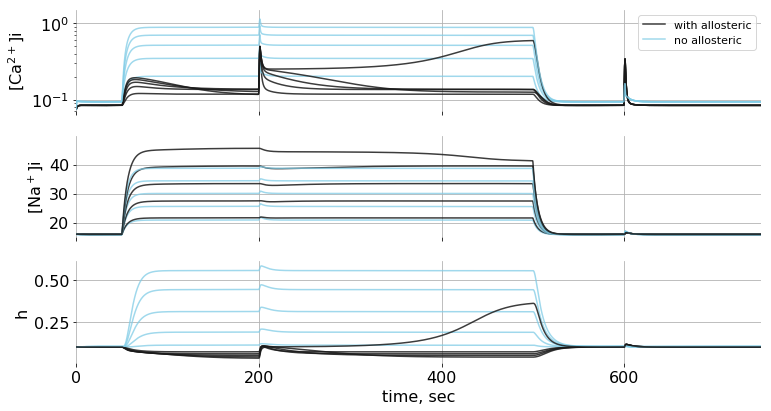

In [113]:

color0=(0.5,0.8,0.9,0.75)
color=(0.1,)*3  + (0.85,)


f,axs = subplots(3,1,sharex=True,figsize=(11,6))

for i, jna in enumerate(Jna_amps):
    lsuff = '_' if i>0 else ''
    axs[0].plot(tv1, traj1[i][:,0],color=color, label=lsuff+'with allosteric')
    axs[0].plot(tv0, traj0[i][:,0],color=color0,label=lsuff+'no allosteric')

    axs[1].plot(tv0, traj0[i][:,1],color=color0)
    axs[1].plot(tv1, traj1[i][:,1],color=color,label='_[Na]$_i$ [mM]')

    axs[2].plot(tv1, traj0[i][:,2],color=color0,label='_h')
    axs[2].plot(tv1, traj1[i][:,2],color=color,label='_h')



setp(axs[0],ylim=(0.07,1.5),ylabel='[Ca$^{2+}$]i',yscale='log')
setp(axs[1],ylim=(15,50),ylabel='[Na$^+$]i')
setp(axs[2],ylabel='h')


#legend(loc=1)
xlabel('time, sec')
#xlim(8,16)
#xlim(500,720)
xlim(0,750)

for ax in axs[:-1]:
    #ax.axvspan(100/60,800/60, color=(0.95,0.95,0.2),alpha=0.25, zorder=-20)
    simpleaxis(ax,2)
    ax.legend(fontsize=11)
simpleaxis(axs[-1])

setp(axs[-1],xticks=range(0,700,200))
setp(axs[1],yticks=[20,30,40])
tight_layout()
#gcf()

## 1D distributed model

In [114]:
def plot_distributed(trajx,var='Ca',idx=(30,36,42),jnarange=(100,800),ax=None, hx=0.5,ls='-',
                     suff = '',
                    ):
    titles=dict(ca=(0,'$[\mathrm{Ca}^{2+}]_i$, μM'),
                na=(1,'$[\mathrm{Na}^+]_i$, μM'),
                h=(2,'$h$'))
    if ax is None:
        _,ax = subplots(1,1)
    #for t in jnarange:
    #    ax.axvline(t/60, ls='--',c='y')
    
    #ax.axvspan(jnarange[0]/60,jnarange[1]/60, color=(0.75,0.75,0.75),alpha=0.25, zorder=-20)
    k,title_ = titles[var.lower()]
    vega_colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728']
    for i,c in zip(idx,vega_colors):
        ieff =  (i-idx[0])*hx
        ax.plot(tvx,trajx[:,k,i],color=c,ls=ls,label=suff+'x=%1.0f μm'%ieff)
    ax.set_xlabel('time, s'); ax.set_title(title_)
    setp(ax, xlabel='time, s', title=title_,ylabel=title_)
    ax.legend(fontsize=12)

In [122]:
#@jit
def distributed_ncx(state,t,N=100, jna=lambda t:0, jca=lambda t:0, 
                    tau_na=6,
                    hx = 1.0, # spatial scale
                    D = 0.5,  # diffusion coefficient
                    ca_slowdown = 5., # how much slower is Ca diffusion than Na diffusion
                    na_flux_mask = ones(100), ca_flux_mask=ones(100),
                    tau_ex=2.0,r=1.,Jmax=0.5,V=Vastro,p=ncx_pars):
    "Simple NCX model with [Ca]i,[Na]i and h (inactivation) as variables, 1D distributed"
    ccai,cnai, h = state
    dna = zeros(N)
    dca = zeros(N)
    dh = zeros(N)
    D_eff = D/hx/hx
    for i in arange(1,N-1):
        jx = Jncx(ccai[i],cnai[i],h[i],Jmax=Jmax,V=V)
        dna[i] =  (cyt['Na']-cnai[i])/tau_na - 3*jx
        dca[i] =  jx + (cyt['Ca']-ccai[i])/(tau_ex)
        dh[i] = (hinf(cnai[i],ccai[i])-h[i])/(htau(ccai[i])/1.)
        
        dca[i] += D_eff*(ccai[i+1]+ccai[i-1]-2*ccai[i])/ca_slowdown
        dna[i] += D_eff*(cnai[i+1]+cnai[i-1]-2*cnai[i])
        
        if na_flux_mask[i]:
            dna[i] += jna(t)
        if ca_flux_mask[i]:
            dca[i] += jca(t)
    
    return array([dca,dna,dh])

In [123]:
Na_pulse_params_ = dict(npulses=7, start=20, period=50, amp=35.,width=0.5,steep=5.,base=0)
Ca_pulse_params_ = dict(npulses=50, start=70+0., period=20, amp=6.0, width=0.5, steep=5., base=0)

Na_pulse = make_pulses(arange(-200,10000,0.2), **Na_pulse_params_)
Ca_pulse = make_pulses(arange(-200,10000,0.2), **Ca_pulse_params_)

In [124]:
shared_params = dict(Jmax=45, jna=Na_pulse,jca=Ca_pulse,tau_ex=2.0,V=-75,ca_slowdown=1)

shared_params['p'] = ncx_pars

ncx_p = shared_params.copy()


In [125]:
N=60
init_st_d = array([cyt['Ca']*ones(N), cyt['Na']*ones(N), 0.1*ones(N)])
na_flux_mask = ones(N,bool)
ca_flux_mask = zeros(N,bool); 
ca_flux_mask[N//2] = True

na_flux_mask = zeros(N,bool); na_flux_mask[N//2:N//2+21] = True

In [126]:
ncx_p_d = ncx_p.copy()
ncx_p_d['ca_flux_mask'] = ca_flux_mask
ncx_p_d['na_flux_mask'] = na_flux_mask
ncx_p_d['N'] = N
ncx_p_d['D'] = 2.0  # Ca diffusion coefficient, μm^2/s
ncx_p_d['hx'] = 0.5    # μm/px
ncx_p_d['Jmax'] = 100

ncx_p_jna_only = ncx_p_d.copy()
ncx_p_jca_only = ncx_p_d.copy()
ncx_p_jna_only['jca'] = lambda t: 0
ncx_p_jca_only['jna'] = lambda t: 0

In [127]:
%%time
numerics_d=dict(dt=0.02,tstop=150)
tvx, trajx = adams_bashforth(distributed_ncx, init_st_d, fnkwargs=ncx_p_d,**numerics_d)

CPU times: user 8.52 s, sys: 0 ns, total: 8.52 s
Wall time: 8.52 s


In [128]:
%%time 
tvx, trajx0ca = adams_bashforth(distributed_ncx, init_st_d, fnkwargs=ncx_p_jna_only,**numerics_d)
tvx, trajx0na = adams_bashforth(distributed_ncx, init_st_d,fnkwargs=ncx_p_jca_only, **numerics_d)

CPU times: user 15.2 s, sys: 23.4 ms, total: 15.3 s
Wall time: 15.2 s


In [129]:

baseline  = trajx[int(5/0.02):int(15/0.02)].mean(0)
traj_linear = (trajx0na+trajx0ca)-baseline
ylinear = traj_linear[:,0]

Text(70,-10,'$\\Delta$[Ca$^{2+}$]i: NCX$-$linear')

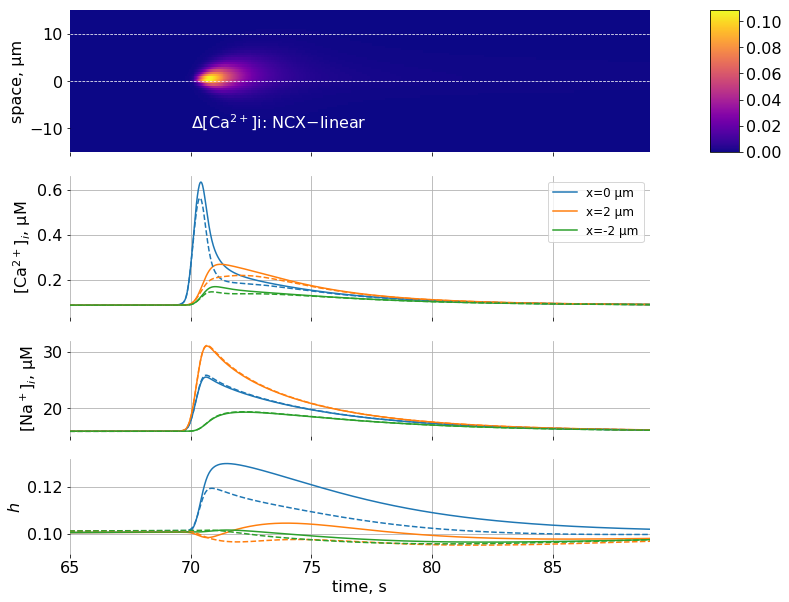

In [130]:
f,axs = subplots(4,2,sharex='col',
                 gridspec_kw=dict(width_ratios=(20,1), height_ratios=(1.5,1.5,1,1,)),
                 figsize=(12,10))

m = axs[0,0].imshow(#trajx[::2,0].T,
                    trajx[::2,0].T-ylinear[::2].T,
                    aspect='auto', cmap=cm.plasma,
                    #vmax=0.1,
                    origin='lower',
                    extent=(tvx[0],tvx[-1],-N*ncx_p_d['hx']/2,N*ncx_p_d['hx']/2)); 
colorbar(m,cax=axs[0,1])

axs[0,0].set_ylabel(u'space, μm')

axs[0,0].grid(False)

plot_distributed(trajx,'Ca', idx=(30, 34, 26),ax=axs[1,0])
plot_distributed(traj_linear,'Ca', idx=(30, 34, 26),ax=axs[1,0],ls='--',suff='_')

plot_distributed(trajx,'Na', idx=(30, 34, 26),ax=axs[2,0],suff='_')
plot_distributed(traj_linear,'Na', idx=(30, 34, 26),ax=axs[2,0],ls='--',suff='_')

plot_distributed(trajx,'h', idx=(30, 34, 26),ax=axs[3,0],suff='_')
plot_distributed(traj_linear,'h', idx=(30, 34, 26),ax=axs[3,0],ls='--',suff='_')



for ax in axs[1:,1]:
    setp(ax,visible=False)

for i,ax in enumerate(axs[:,0]):
    if i>-1: ax.set_title('')
    if i<3: 
        simpleaxis(ax,2)
        ax.set_xlabel('')
    else: simpleaxis(ax,1)


axs[0,0].axhline(0,ls='--',color='w',lw=0.75)
axs[0,0].axhline(10,ls='--',color='w',lw=0.75)


axs[0,0].set_xlim(65,89)
axs[0,0].text(70,-10, '$\Delta$[Ca$^{2+}$]i: NCX$-$linear',color='w')


-------------_